In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantbullet.model.neighbors import FeatureScaledKNNRegressor
from datetime import date

## Illustration Example

In [6]:
# Class 0: centered at (1, 1)
X0 = np.random.randn(10, 2) * 0.2 + [0, 0]
y0 = np.zeros(10)

# Class 1: centered at (4, 4)
X1 = np.random.randn(10, 2) * 0.2 + [2, 2]
y1 = np.ones(10)

# Combine
X = np.vstack((X0, X1))
y = np.hstack((y0, y1))

In [4]:
regressor = FeatureScaledKNNRegressor(
    n_neighbors=5,
    metrics = 'euclidean',
    weights = 'uniform',
    feature_weights=[10, 1],
)

regressor.fit(pd.DataFrame(X, columns=['feature1', 'feature2']), y)

neighbors_ = regressor.predict_with_neighbors([[ 0, 2 ]])

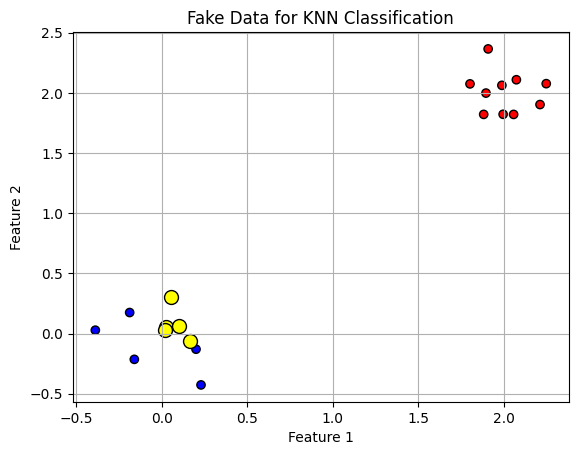

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k')
plt.scatter(neighbors_['feature1'], neighbors_['feature2'], c='yellow', edgecolor='k', s=100, label='Neighbors')
plt.title("Fake Data for KNN Classification")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()